In [1]:
################# imports  ################
import SciServer
from SciServer import Authentication, LoginPortal, Config, CasJobs, SkyQuery, SciDrive, SkyServer, Files, Jobs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii, fits
from astropy.table import Table, join, hstack,vstack,QTable
from astropy.table import Table
import healpy as hp

from astropy.coordinates import SkyCoord
from astropy import units as u

## Funções

In [2]:
def RaDec_to_radian(array_ra, array_dec):
    '''Transforma ra e dec(em graus) em coordenadas esféricas phi e theta'''
    #theta =  [np.pi/2] - dec_radian
    #phi =  ra_radian
    array_ra_phi_radian=[]
    array_dec_theta_radian=[]
    for i in range(len(array_ra)):
        c_icrs = SkyCoord(ra=array_ra[i]*u.degree, dec=array_dec[i]*u.degree, frame='icrs')
        array_ra_phi_radian.append(c_icrs.ra.radian)
        array_dec_theta_radian.append(np.pi/2 - c_icrs.dec.radian)
    return array_ra_phi_radian,array_dec_theta_radian

In [3]:
def ang_to_pixel (ra_array,dec_array,Nside):
    '''
    recebe em um array as coordenadas RA em degrees
    recebe em um array as coordenadas DEC em degrees
    return - uma lista com os pixels
    '''
    phi, theta = RaDec_to_radian(ra_array, dec_array)
    indices = hp.ang2pix(Nside, theta, phi) #, lonlat=True
    return indices

## Carregamento dos dados 

In [4]:
################# Sloan Data ################
################# credenciais  ################
# Define login Name and password before running these examples
Authentication_loginName = 'cammiillac'
Authentication_loginPassword = 'Averdade24-12'
token1 = Authentication.login(Authentication_loginName, Authentication_loginPassword)

In [5]:
################# query ################
#get a Pandas dataframe containing the results of a query
# Para mais informações sobre os schemas e tabelas do DR16 --> http://skyserver.sdss.org/dr16/en/home.aspx?token=2138603d7a5f4bf2ac1ea1c6a40e2e5c
CasJobs_Database = "DR16"
CasJobs_Query = "select specObjID, survey, instrument,class,ra, dec, z, zErr from SpecObj"
sloan_data_best_results = CasJobs.getPandasDataFrameFromQuery(queryString=CasJobs_Query, context=CasJobs_Database)

## Processamento dos dados 

In [28]:
# Dividir os dados do sloan em 4 categorias 

# Data frame que tem os objetos classificados como galáxias
sloan_data_galaxy = sloan_data_best_results[sloan_data_best_results['class']=='GALAXY'].reset_index(drop=True)

# Data frame que tem os objetos classificados como estrelas
sloan_data_star = sloan_data_best_results[sloan_data_best_results['class']=='STAR'].reset_index(drop=True)

# Data frame que tem os objetos classificados como quasares
sloan_data_quasar = sloan_data_best_results[sloan_data_best_results['class']=='QSO'].reset_index(drop=True)

# Data frame com todos os dados
sloan_all = sloan_data_best_results.reset_index(drop=True)

In [34]:
Nside = 64
Npix = hp.nside2npix(Nside) # Definição de Npix - 12*(Nside)**2

# Criando um dataframe para a plotagem do mollview 
pixels_location = pd.DataFrame()
pixels_location['indices'] = np.arange(Npix)

In [9]:
############ QUASARES ############
quasares_pixels_location = pd.DataFrame()
quasares_pixels_location['indices'] = ang_to_pixel(sloan_data_quasar['ra'].values, sloan_data_quasar['dec'].values, Nside)
quasares_pixels_grouped = quasares_pixels_location.groupby(['indices']).size().reset_index(name='counts')

sloan_data_quasar['Npix'] = quasares_pixels_location['indices']
sloan_data_quasar_table = Table.from_pandas(sloan_data_quasar)
sloan_data_quasar_table.write('/media/new-drive/CamilaCardoso/SLOAN/SLOAN_DR16_sloan_data_quasar_all.fits')

In [12]:
df = Table.read('SLOAN/SLOAN_DR16_data_quasars_pixels_location.fits').to_pandas()

In [25]:
############ GALAXY ############
galaxy_pixels_location = pd.DataFrame()
galaxy_pixels_location['indices'] = ang_to_pixel(sloan_data_galaxy['ra'].values, sloan_data_galaxy['dec'].values, Nside)
galaxy_pixels_grouped = galaxy_pixels_location.groupby(['indices']).size().reset_index(name='counts')

sloan_data_galaxy['Npix'] = galaxy_pixels_location['indices']
sloan_data_galaxy_table = Table.from_pandas(sloan_data_galaxy)
sloan_data_galaxy_table.write('/media/new-drive/CamilaCardoso/SLOAN/SLOAN_DR16_sloan_data_galaxy_all.fits')

In [30]:
############ STAR ############
star_pixels_location = pd.DataFrame()
star_pixels_location['indices'] = ang_to_pixel(sloan_data_star['ra'].values, sloan_data_star['dec'].values, Nside)
star_pixels_grouped = star_pixels_location.groupby(['indices']).size().reset_index(name='counts')

sloan_data_star['Npix'] = star_pixels_location['indices']
sloan_data_star_table = Table.from_pandas(sloan_data_star)
sloan_data_star_table.write('/media/new-drive/CamilaCardoso/SLOAN/SLOAN_DR16_sloan_data_star_all.fits')

In [ ]:
############ ALL ############
sloan_all_pixels_location = pd.DataFrame()
sloan_all_pixels_location['indices'] = ang_to_pixel(sloan_all['ra'].values, sloan_all['dec'].values, Nside)
sloan_all_pixels_grouped = sloan_all_pixels_location.groupby(['indices']).size().reset_index(name='counts')

In [ ]:
#realiza um merge entre um dataframe contendo todos os pixels e o dataframe com os objetos agrupados por pixels
############ QUASARES ############
quasars_pixels_frequency = pd.merge(pixels_location, quasares_pixels_grouped, how = 'outer')
quasars_pixels_frequency = quasars_pixels_frequency.fillna(0) 
############ STARS ############
stars_pixels_frequency = pd.merge(pixels_location, star_pixels_grouped, how = 'outer')
stars_pixels_frequency = stars_pixels_frequency.fillna(0)
############ GALAXYS ############
galaxys_pixels_frequency = pd.merge(pixels_location, galaxy_pixels_grouped, how = 'outer')
galaxys_pixels_frequency = galaxys_pixels_frequency.fillna(0)

## Plot

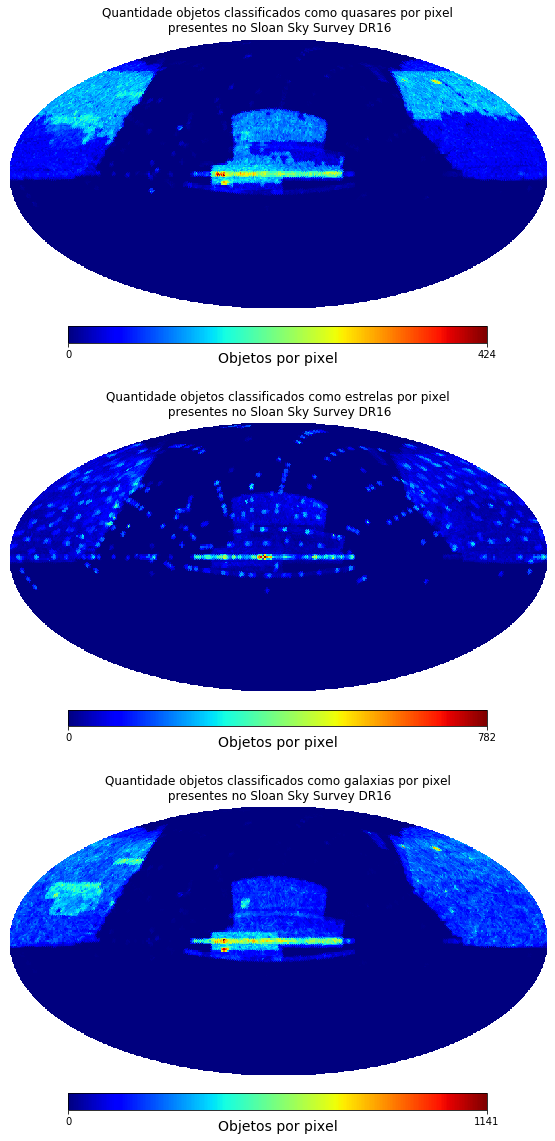

In [65]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
plt.figure(figsize=(15,20))
plt.subplot(311)
hp.mollview(quasars_pixels_frequency.counts.values, title="Quantidade objetos classificados como quasares por pixel\n presentes no Sloan Sky Survey DR16", unit='Objetos por pixel', cmap='jet', hold =True )
plt.subplot(312)
hp.mollview(stars_pixels_frequency.counts.values, title="Quantidade objetos classificados como estrelas por pixel\n presentes no Sloan Sky Survey DR16", unit=r'Objetos por pixel',cmap='jet', hold =True )
plt.subplot(313)
hp.mollview(galaxys_pixels_frequency.counts.values, title="Quantidade objetos classificados como galaxias por pixel\n presentes no Sloan Sky Survey DR16", unit=r'Objetos por pixel',cmap='jet', hold =True )
plt.savefig('sloan_homogeneity_analysis.png', format='png')
plt.show()